# Recommendation by Character images

#### ToDo

- [x] Preparations
    - [x] data retrieval
    - [x] convert images to black and white
    - [x] set transformations (`ToTensor()`, `RandomCrop()`)
    - [x] create Dataset
    - [x] create Dataloader
- [ ] Representation learning: try with few images
    - [ ] define encoder
    - [ ] define decoder
    - [ ] embedding function
    - [ ] training and validation codes
    - [ ] training visualization
- [ ] Scale up data
    - [ ] train with larger data
    - [ ] create and save representation data
- [ ] Similarity calculation
    - [ ] convert character-based representation to title-based representation (sum for each title?)
    - [ ] NN function
    - [ ] KD-tree index if inefficient
- [ ] Recommendation
    - [ ] recommender function


- [ ] Refactoring
    - [ ] none

#### Other
- [ ] xxxxx
- [ ] xxxxx
- [ ] xxxxx

#### Notes
1. Make training data stratified (certain proportion for each author)
2. Don’t use RGB, but black&white (single scalar value to represent 1 pixel)
3. Padding needs to be flexible
4. not sure about augmentation, but random clipping might work


In [166]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

# images
# import cv2
from PIL import Image
import matplotlib.pyplot as plt

# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader, random_split

## Data retrieval

In [17]:
# # 20p -> 100 titles -> 2111 character images
# # 200p -> 6231 titles -> 39939 images

# df_charas = pd.read_csv("../assets/characters_200p.csv")
# display(df_charas.head())
# print(len(df_charas["title_id"].unique()))
# print(len(df_charas["character_id"].unique()))

In [18]:
# # Reduce the data down to first 500 titles
# first_500_titles = df_charas["title_id"].unique()[:500]
# df_charas_reduced = df_charas[df_charas["title_id"].isin(first_500_titles)]
# print(len(df_charas_reduced))
# df_charas_reduced = df_charas_reduced.drop_duplicates(subset="character_image_url")
# print(len(df_charas_reduced))
# print(len(df_charas_reduced["title_id"].unique()))
# print(len(first_500_titles))
# print(len(df_charas_reduced["character_id"].unique()))
# print(len(df_charas_reduced["character_image_url"].unique()))

# # save
# df_charas_reduced.to_csv("../assets/characters_498_titles", index=False)

## Image conversion: from RGB to grayscale

In [25]:
# get one image
img = Image.open("../assets/character_images/character_images/10138.png").convert("L")
print(img.format, img.size, img.mode)
img.save("../assets/character_images/character_images_grayscale/10138.png")

None (230, 345) L


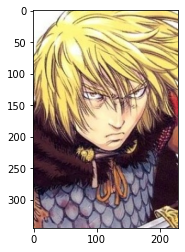

In [30]:
img = Image.open("../assets/character_images/character_images/10138.png")
plt.imshow(np.array(img))

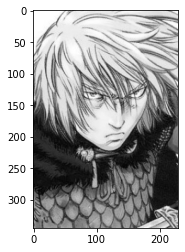

In [38]:
# Confirm grayscale conversion succeeds
img = Image.open("../assets/character_images/character_images_grayscale/10138.png")
plt.imshow(np.array(img), cmap="gray")

In [177]:
# # convert all images to grayscale
# img_list = os.listdir("../assets/character_images/character_images/")
# for img in tqdm(img_list):
#     try:
#         grey_img = Image.open("../assets/character_images/character_images/"+img).convert("L")
#         grey_img.save("../assets/character_images/character_images_grayscale/"+img)
#     except:
#         print("error at: ", img)

In [152]:
# check if all images have been converted
print(len(os.listdir("../assets/character_images/character_images/")))
print(len(os.listdir("../assets/character_images/character_images_grayscale/")))

7798
7798


## Check image sizes

In [153]:
# Research possible size patterns first
img_list = os.listdir("../assets/character_images/character_images/")
size_patterns = []
for img in img_list:
    try:
        grey_img = np.array(Image.open("../assets/character_images/character_images_grayscale/"+img))
        size_patterns.append(grey_img.shape) # each shape is (h,w)
        # checking the id of small and large images
        if (grey_img.shape[0] < 80) or (grey_img.shape[0] > 450):
            print(img)
        elif (grey_img.shape[1] < 80):
            print(img)
    except:
        pass

262137.png
183076.png
133532.png
131808.png
183075.png
82573.png
8778.png
120852.png


In [154]:
# Find the max size: each tuple is (height, width)
max_height_img = sorted(size_patterns, key=lambda x: x[0], reverse=True)[0]
max_width_img = sorted(size_patterns, key=lambda x: x[1], reverse=True)[0]
print("max height and max width images: ", max_height_img, max_width_img)

# Find the min size
min_height_img = sorted(size_patterns, key=lambda x: x[0], reverse=False)[0]
min_width_img = sorted(size_patterns, key=lambda x: x[1], reverse=False)[0]
print("min height and min width images: ", min_height_img, min_width_img)

# height can vary from 72 to 491
# width can vary from 78 to 230

# examples of small/large images 
# 262137.png # big (450, 230 ish)
# 183076.png
# 133532.png
# 131808.png
# 183075.png
# 82573.png # (72, 140)
# 8778.png # (97, 78)
# 120852.png

# 
display(pd.Series(size_patterns).value_counts())

max height and max width images:  (491, 230) (326, 230)
min height and min width images:  (72, 140) (97, 78)


(345, 230)    3251
(358, 230)    1005
(350, 225)     943
(360, 230)     297
(344, 230)     221
              ... 
(301, 230)       1
(81, 121)        1
(450, 230)       1
(280, 181)       1
(285, 208)       1
Length: 500, dtype: int64

## Image transformation

shape before transformation:  (487, 230)
shape after transformation:  torch.Size([1, 200, 200])


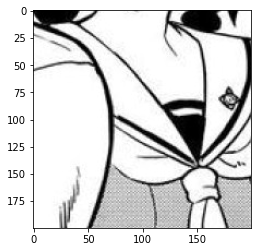

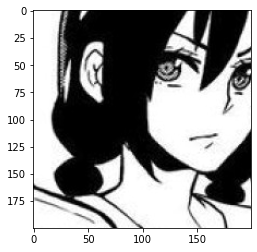

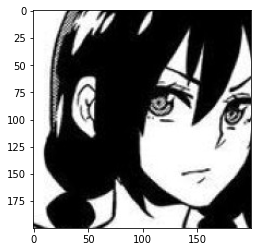

In [155]:
# transform: check cropping process
try_transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.RandomCrop(200, pad_if_needed=True)
                                  ])

img = Image.open("../assets/character_images/character_images_grayscale/183076.png")

# check: tensor conversion and addition of channel dimension
img_before = np.array(img)
img_after = try_transform(img)
print("shape before transformation: ", img_before.shape) # [h,w]
print("shape after transformation: ", img_after.size()) # [c,h,w]

# check: if small/large images are cropped ok (padded if img is small)
imgs_after = [try_transform(img) for _ in range(3)]
back_transform = transforms.Compose([transforms.ToPILImage()])
for img in imgs_after:
    pil_img = back_transform(img)
    plt.imshow(np.array(pil_img), cmap="gray")
    plt.show()

## Dataset and Dataloader

In [176]:
# # quick preparation of trial data
# img_list = os.listdir("../assets/character_images/character_images/")
# for img in tqdm(img_list[:100]):
#     try:
#         grey_img = Image.open("../assets/character_images/character_images/"+img).convert("L")
#         grey_img.save("../assets/character_images/character_images_grayscale_test/"+img)
#     except:
#         print("error at: ", img)

In [163]:
class MangaDataset(Dataset):

    def __init__(self, target_dir, transform_steps=None):
        self.target_dir = target_dir
        self.transform_steps = transform_steps
        self.target_imgs = os.listdir(target_dir)

    def __len__(self):
        return len(self.target_imgs)

    def __getitem__(self, idx):
        img_path = os.path.join(self.target_dir, self.target_imgs[idx])
        img = Image.open(img_path)

        if self.transform:
            tensor_img = self.transform_steps(img)

        return tensor_img, tensor_img # first is input to the model, second is input for reconstruction
    

In [167]:
# Define transformations and initialize Dataset
transform_steps = transforms.Compose([transforms.ToTensor(),
                                      transforms.RandomCrop(200, pad_if_needed=True)
                                     ])
manga_dataset = MangaDataset("../assets/character_images/character_images_grayscale_test", transform_steps)

In [175]:
# Set DataLoader

# Split train and data
train_size = int(manga_dataset.__len__() * 0.75)
val_size = int(manga_dataset.__len__() - train_size)
train_dataset, val_dataset = random_split(manga_dataset, [train_size, val_size]) 

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# All dataloader
all_data_loader = DataLoader(manga_dataset, batch_size=32)